<a href="https://colab.research.google.com/github/bygencer3/ErdincGencer_Odev_254329028-/blob/main/YapaySinirAglari_Final_254329028_Erdinc_Gencer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split

# Reprodüksiyon için seed sabitleme
tf.random.set_seed(42)
np.random.seed(42)

# Veri yolunu kendi sistemine göre güncelle
data_dir = "/content/drive/MyDrive/SkinCancer/Train"

# Klasörleri tara ve en büyük iki sınıfı seç
all_classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in all_classes}

top_2 = sorted(class_counts, key=class_counts.get, reverse=True)[:2]
class_A, class_B = top_2[0], top_2[1]

print(f"Seçilen Sınıflar: 0 -> {class_A}, 1 -> {class_B}")

# DataFrame oluşturma (Sadece seçilen iki sınıf)
filepaths, labels = [], []
for i, cls in enumerate(top_2):
    cls_path = os.path.join(data_dir, cls)
    for img in os.listdir(cls_path):
        filepaths.append(os.path.join(cls_path, img))
        labels.append(i)

df = pd.DataFrame({'path': filepaths, 'label': labels})
print(f"Toplam kullanılacak görüntü sayısı: {len(df)}")

Seçilen Sınıflar: 0 -> pigmented benign keratosis, 1 -> melanoma
Toplam kullanılacak görüntü sayısı: 900


In [3]:
# Veri setini Train / Validation / Test olarak ayır (Stratified)
train_df, test_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.50, stratify=test_df['label'], random_state=42)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def load_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return tf.cast(img, tf.float32) / 255.0, label

# Sadece Train için Data Augmentation
aug_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15), # +-15 derece
    layers.RandomZoom(0.1)
])

def prepare_ds(dataframe, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((dataframe['path'], dataframe['label']))
    ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (aug_layer(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = prepare_ds(train_df, augment=True)
val_ds = prepare_ds(val_df)
test_ds = prepare_ds(test_df)

print("Veri setleri başarıyla oluşturuldu.")

Veri setleri başarıyla oluşturuldu.


In [ ]:
def build_scratch():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),

        # Blok 1
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        # Blok 2
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        # Head
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

scratch_model = build_scratch()
scratch_model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
custom_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Eğitimi başlat
print("Scratch CNN eğitimi başlıyor...")
history_scratch = scratch_model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=custom_callbacks)

Scratch CNN eğitimi başlıyor...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 121s 6s/step - accuracy: 0.6774 - loss: 0.5695 - val_accuracy: 0.5111 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.8651 - loss: 0.3582 - val_accuracy: 0.5111 - val_loss: 0.7034 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 0.8549 - loss: 0.3480 - val_accuracy: 0.5111 - val_loss: 0.7174 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - accuracy: 0.8606 - loss: 0.3301 - val_accuracy: 0.5111 - val_loss: 0.7311 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.8725 - loss: 0.3183 - val_accuracy: 0.5111 - val_loss: 0.7492 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step - accuracy: 0.8699 - loss: 0.2841 - val_accuracy: 0.5111 - val_loss: 0.7887 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accur

In [ ]:
# Callbacks Tanımı
custom_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )
]

# Scratch CNN Eğitimini Başlat
print("Scratch CNN eğitimi başlıyor...")
history_scratch = scratch_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=custom_callbacks
)

Scratch CNN eğitimi başlıyor...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.8369 - loss: 0.3878 - val_accuracy: 0.5111 - val_loss: 0.6808 - learning_rate: 4.0000e-05
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.8626 - loss: 0.3201 - val_accuracy: 0.5111 - val_loss: 0.6807 - learning_rate: 4.0000e-05
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.8651 - loss: 0.3366 - val_accuracy: 0.5111 - val_loss: 0.6778 - learning_rate: 4.0000e-05
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.8691 - loss: 0.3035 - val_accuracy: 0.5111 - val_loss: 0.6737 - learning_rate: 4.0000e-05
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.8836 - loss: 0.3150 - val_accuracy: 0.5111 - val_loss: 0.6691 - learning_rate: 4.0000e-05
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.8724 - loss: 0.3125 - val_accuracy: 0.5185 - val_loss: 0.6642 - learning_rate: 4.0000e-05
Epoch 7/100
20/20 ━━━━━━━━━━━━━━

In [ ]:
# MobileNetV2 Modelini İnşa Et
base_mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Aşama 1: Katmanları Dondur
base_mobilenet.trainable = False

model_mobilenet = models.Sequential([
    base_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_mobilenet.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("MobileNetV2 Aşama-1 (Freeze) eğitimi başlıyor...")
history_mobilenet_stage1 = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=custom_callbacks
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 Aşama-1 (Freeze) eğitimi başlıyor...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5451 - loss: 0.7789 - val_accuracy: 0.6296 - val_loss: 0.6881 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6343 - loss: 0.6952 - val_accuracy: 0.6370 - val_loss: 0.6217 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6438 - loss: 0.6546 - val_accuracy: 0.7037 - val_loss: 0.5890 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6889 - loss: 0.5905 - val_accuracy: 0.6815 - val_loss: 0.5731 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6811 - loss: 0.6050 - val_accuracy: 0.6889 - val_loss: 0.5667 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7295 - loss: 0.5495 - val_accuracy: 0.6963 - val_loss: 0.5613 - learning_rate: 0.0

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split

# Reprodüksiyon için seed sabitleme
tf.random.set_seed(42)
np.random.seed(42)

# Veri yolunu kendi sistemine göre güncelle
data_dir = "/content/drive/MyDrive/SkinCancer/Train"

# Klasörleri tara ve en büyük iki sınıfı seç
all_classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in all_classes}

top_2 = sorted(class_counts, key=class_counts.get, reverse=True)[:2]
class_A, class_B = top_2[0], top_2[1]

print(f"Seçilen Sınıflar: 0 -> {class_A}, 1 -> {class_B}")

# DataFrame oluşturma (Sadece seçilen iki sınıf)
filepaths, labels = [], []
for i, cls in enumerate(top_2):
    cls_path = os.path.join(data_dir, cls)
    for img in os.listdir(cls_path):
        filepaths.append(os.path.join(cls_path, img))
        labels.append(i)

df = pd.DataFrame({'path': filepaths, 'label': labels})
print(f"Toplam kullanılacak görüntü sayısı: {len(df)}")

# Veri setini Train / Validation / Test olarak ayır (Stratified)
train_df, test_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.50, stratify=test_df['label'], random_state=42)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def load_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return tf.cast(img, tf.float32) / 255.0, label

# Data Augmentation layer
aug_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1)
])

def prepare_ds(dataframe, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((dataframe['path'], dataframe['label']))
    ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (aug_layer(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = prepare_ds(train_df, augment=True)
val_ds = prepare_ds(val_df)

# Callbacks
custom_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )
]

# MobileNetV2 Modelini İnşa Et
base_mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Aşama 1: Katmanları Dondur
base_mobilenet.trainable = False

model_mobilenet = models.Sequential([
    base_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_mobilenet.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("MobileNetV2 Aşama-1 (Freeze) eğitimi başlıyor...")
history_mobilenet_stage1 = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=custom_callbacks
)

Seçilen Sınıflar: 0 -> pigmented benign keratosis, 1 -> melanoma
Toplam kullanılacak görüntü sayısı: 900
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MobileNetV2 Aşama-1 (Freeze) eğitimi başlıyor...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 193s 9s/step - accuracy: 0.5402 - loss: 0.7371 - val_accuracy: 0.6296 - val_loss: 0.6968 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6377 - loss: 0.6546 - val_accuracy: 0.7111 - val_loss: 0.5954 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6690 - loss: 0.6034 - val_accuracy: 0.7037 - val_loss: 0.5773 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6886 - loss: 0.5828 - val_accuracy: 0.6963 - val_loss: 0.5784 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7069 - loss: 0.5998 - val_accuracy: 0.7333 - val_loss: 0.5665 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 42

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# 1. AŞAMA: Feature Extraction (Freeze) [cite: 92]
base_mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_mobilenet.trainable = False # Tüm katmanlar donduruldu [cite: 93]

model_mobilenet = models.Sequential([
    base_mobilenet,
    layers.GlobalAveragePooling2D(), # GAP kullanımı [cite: 96]
    layers.Dropout(0.3), # Overfitting önlemi [cite: 97]
    layers.Dense(1, activation='sigmoid') # İkili sınıflandırma çıkışı [cite: 98]
])

model_mobilenet.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3), # Başlangıç LR [cite: 100]
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("MobileNetV2 Aşama-1 (Freeze) eğitimi başlıyor...")
model_mobilenet.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=custom_callbacks)

# 2. AŞAMA: Fine-Tuning (Son %25'i Açma) [cite: 111]
base_mobilenet.trainable = True
n_layers = len(base_mobilenet.layers)
fine_tune_at = int(n_layers * 0.75) # Son %25 kuralı [cite: 114]

# İlk %75'lik kısmı dondur
for layer in base_mobilenet.layers[:fine_tune_at]:
    layer.trainable = False # [cite: 115]

model_mobilenet.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5), # Fine-tuning için düşük LR [cite: 123]
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nMobileNetV2 Aşama-2 (Fine-Tuning) eğitimi başlıyor...")
model_mobilenet.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=custom_callbacks)

MobileNetV2 Aşama-1 (Freeze) eğitimi başlıyor...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5319 - loss: 0.7678 - val_accuracy: 0.6519 - val_loss: 0.6440 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6233 - loss: 0.6948 - val_accuracy: 0.6963 - val_loss: 0.5869 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6098 - loss: 0.6862 - val_accuracy: 0.7185 - val_loss: 0.5721 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7028 - loss: 0.5792 - val_accuracy: 0.7185 - val_loss: 0.5644 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7066 - loss: 0.5768 - val_accuracy: 0.7481 - val_loss: 0.5492 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7024 - loss: 0.5552 - val_accuracy: 0.7481 - val_loss: 0.5398 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s

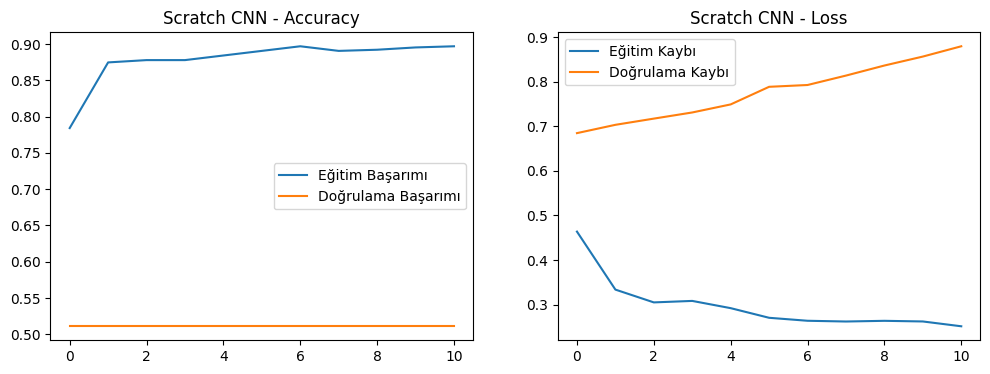

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Eğitim Başarımı')
    plt.plot(epochs_range, val_acc, label='Doğrulama Başarımı')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Eğitim Kaybı')
    plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

# Örnek kullanım:
plot_history(history_scratch, "Scratch CNN")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_335']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


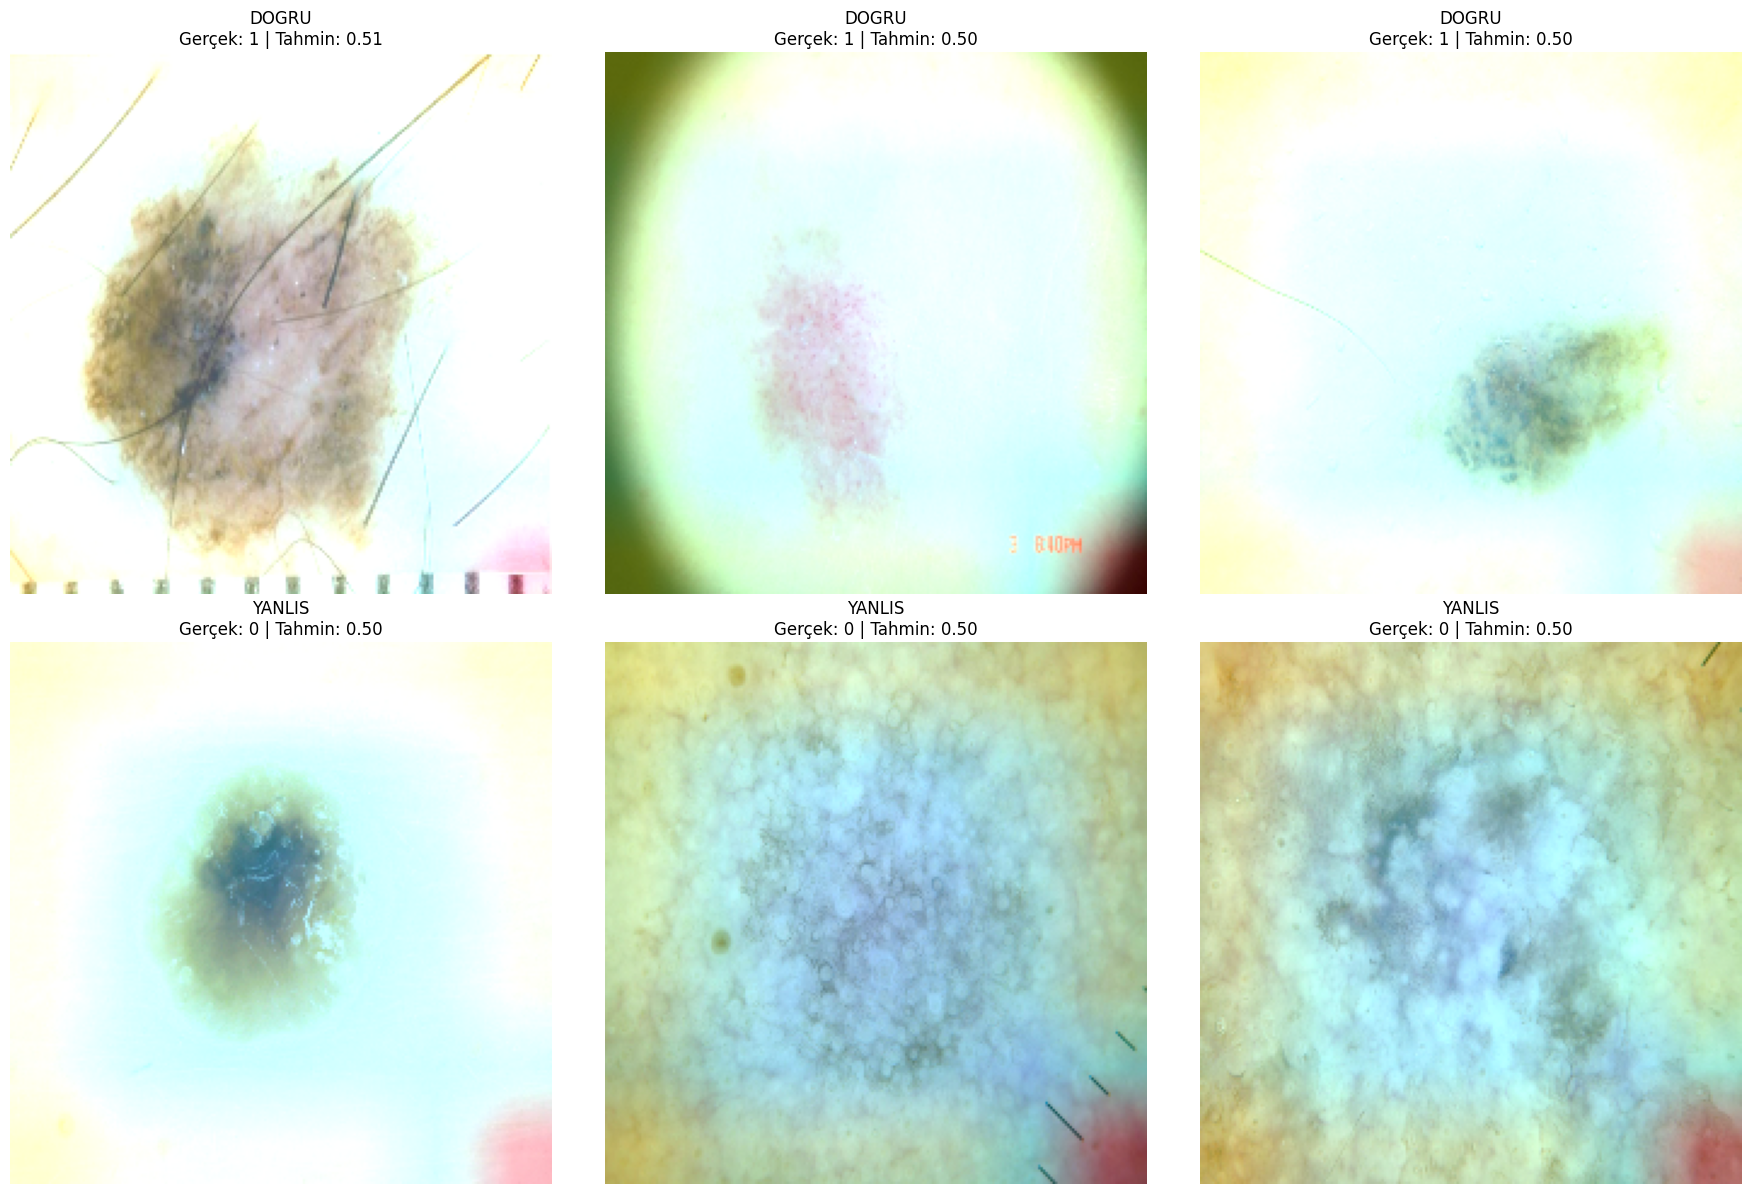

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def get_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Eğer katman ana modelde değilse, base_model içinden bul (EfficientNet/MobileNet için)
    try:
        target_layer = model.get_layer(last_conv_layer_name)
    except ValueError:
        # Sequential modelin ilk katmanı genellikle base modeldir
        base_model = model.layers[0]
        target_layer = base_model.get_layer(last_conv_layer_name)
        model = base_model # Gradyan takibi için base model üzerinden devam et

    grad_model = tf.keras.models.Model(
        [model.inputs], [target_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        # Sınıf kanalını seç (ikili sınıflandırma için sigmoid çıkışı) [cite: 74, 98]
        class_channel = preds[:, 0]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    # Görüntüleri birleştir
    return jet_heatmap * alpha + img

# --- ANALİZ VE GÖRSELLEŞTİRME ---
model_to_analyze = model_effnet
# EfficientNetB0 için son konvolüsyon katmanı genellikle 'top_conv'dur.
target_layer = "top_conv"

# Test setinden 3 doğru ve varsa 3 yanlış örnek seçelim [cite: 148, 149, 150]
images, labels = next(iter(test_ds))
preds = model_to_analyze.predict(images).flatten()
binary_preds = (preds > 0.5).astype(int)

correct_idxs = np.where(binary_preds == labels.numpy())[0][:3]
wrong_idxs = np.where(binary_preds != labels.numpy())[0][:3]
selected_idxs = np.concatenate([correct_idxs, wrong_idxs])

plt.figure(figsize=(18, 12))
for i, idx in enumerate(selected_idxs):
    img = images[idx].numpy()
    heatmap = get_gradcam_heatmap(images[idx:idx+1], model_to_analyze, target_layer)
    combined = overlay_heatmap(img, heatmap)

    status = "DOGRU" if i < 3 else "YANLIS"
    plt.subplot(2, 3, i+1)
    plt.imshow(combined)
    plt.title(f"{status}\nGerçek: {labels[idx]} | Tahmin: {preds[idx]:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 837ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


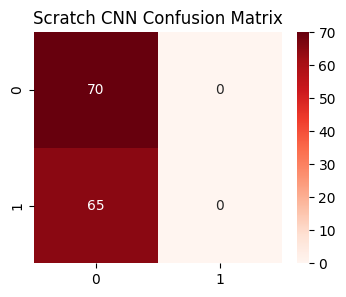

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 871ms/step


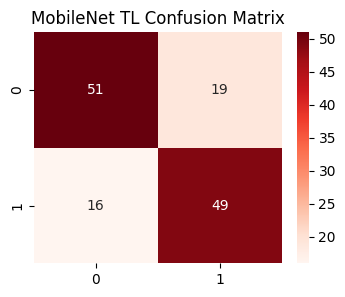

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


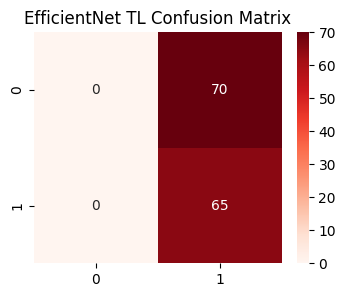


--- FINAL KARŞILAŞTIRMA TABLOSU ---
             Model  Accuracy  Precision    Recall        F1   ROC-AUC
0      Scratch CNN  0.518519   0.000000  0.000000  0.000000  0.927692
1     MobileNet TL  0.740741   0.720588  0.753846  0.736842  0.853407
2  EfficientNet TL  0.481481   0.481481  1.000000  0.650000  0.504286


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_and_get_metrics(model, ds, name):
    # Tahminleri al
    y_true = np.concatenate([y for x, y in ds], axis=0)
    y_pred_probs = model.predict(ds).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Metrikleri hesapla [cite: 133-137]
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_pred_probs)
    }

    # ROC verilerini sakla
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_data = (fpr, tpr, auc(fpr, tpr))

    # Confusion Matrix [cite: 139]
    cm = confusion_matrix(y_true, y_pred)

    return metrics, roc_data, cm

# Not: Modellerin eğitildiğinden emin olun (model_scratch, model_mobilenet, model_effnet)
results_list = []
roc_curves = []

# Her model için değerlendirme yap
for m, n in zip([scratch_model, model_mobilenet, model_effnet],
                ["Scratch CNN", "MobileNet TL", "EfficientNet TL"]):
    m_metrics, m_roc, m_cm = evaluate_and_get_metrics(m, test_ds, n)
    results_list.append(m_metrics)
    roc_curves.append(m_roc)

    # CM Görselleştirme
    plt.figure(figsize=(4,3))
    sns.heatmap(m_cm, annot=True, fmt='d', cmap='Reds')
    plt.title(f"{n} Confusion Matrix")
    plt.show()

# Karşılaştırma Tablosu [cite: 142]
df_comparison = pd.DataFrame(results_list)
print("\n--- FINAL KARŞILAŞTIRMA TABLOSU ---")
print(df_comparison)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

--- EfficientNet TL Grad-CAM Analizi ---


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_335']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


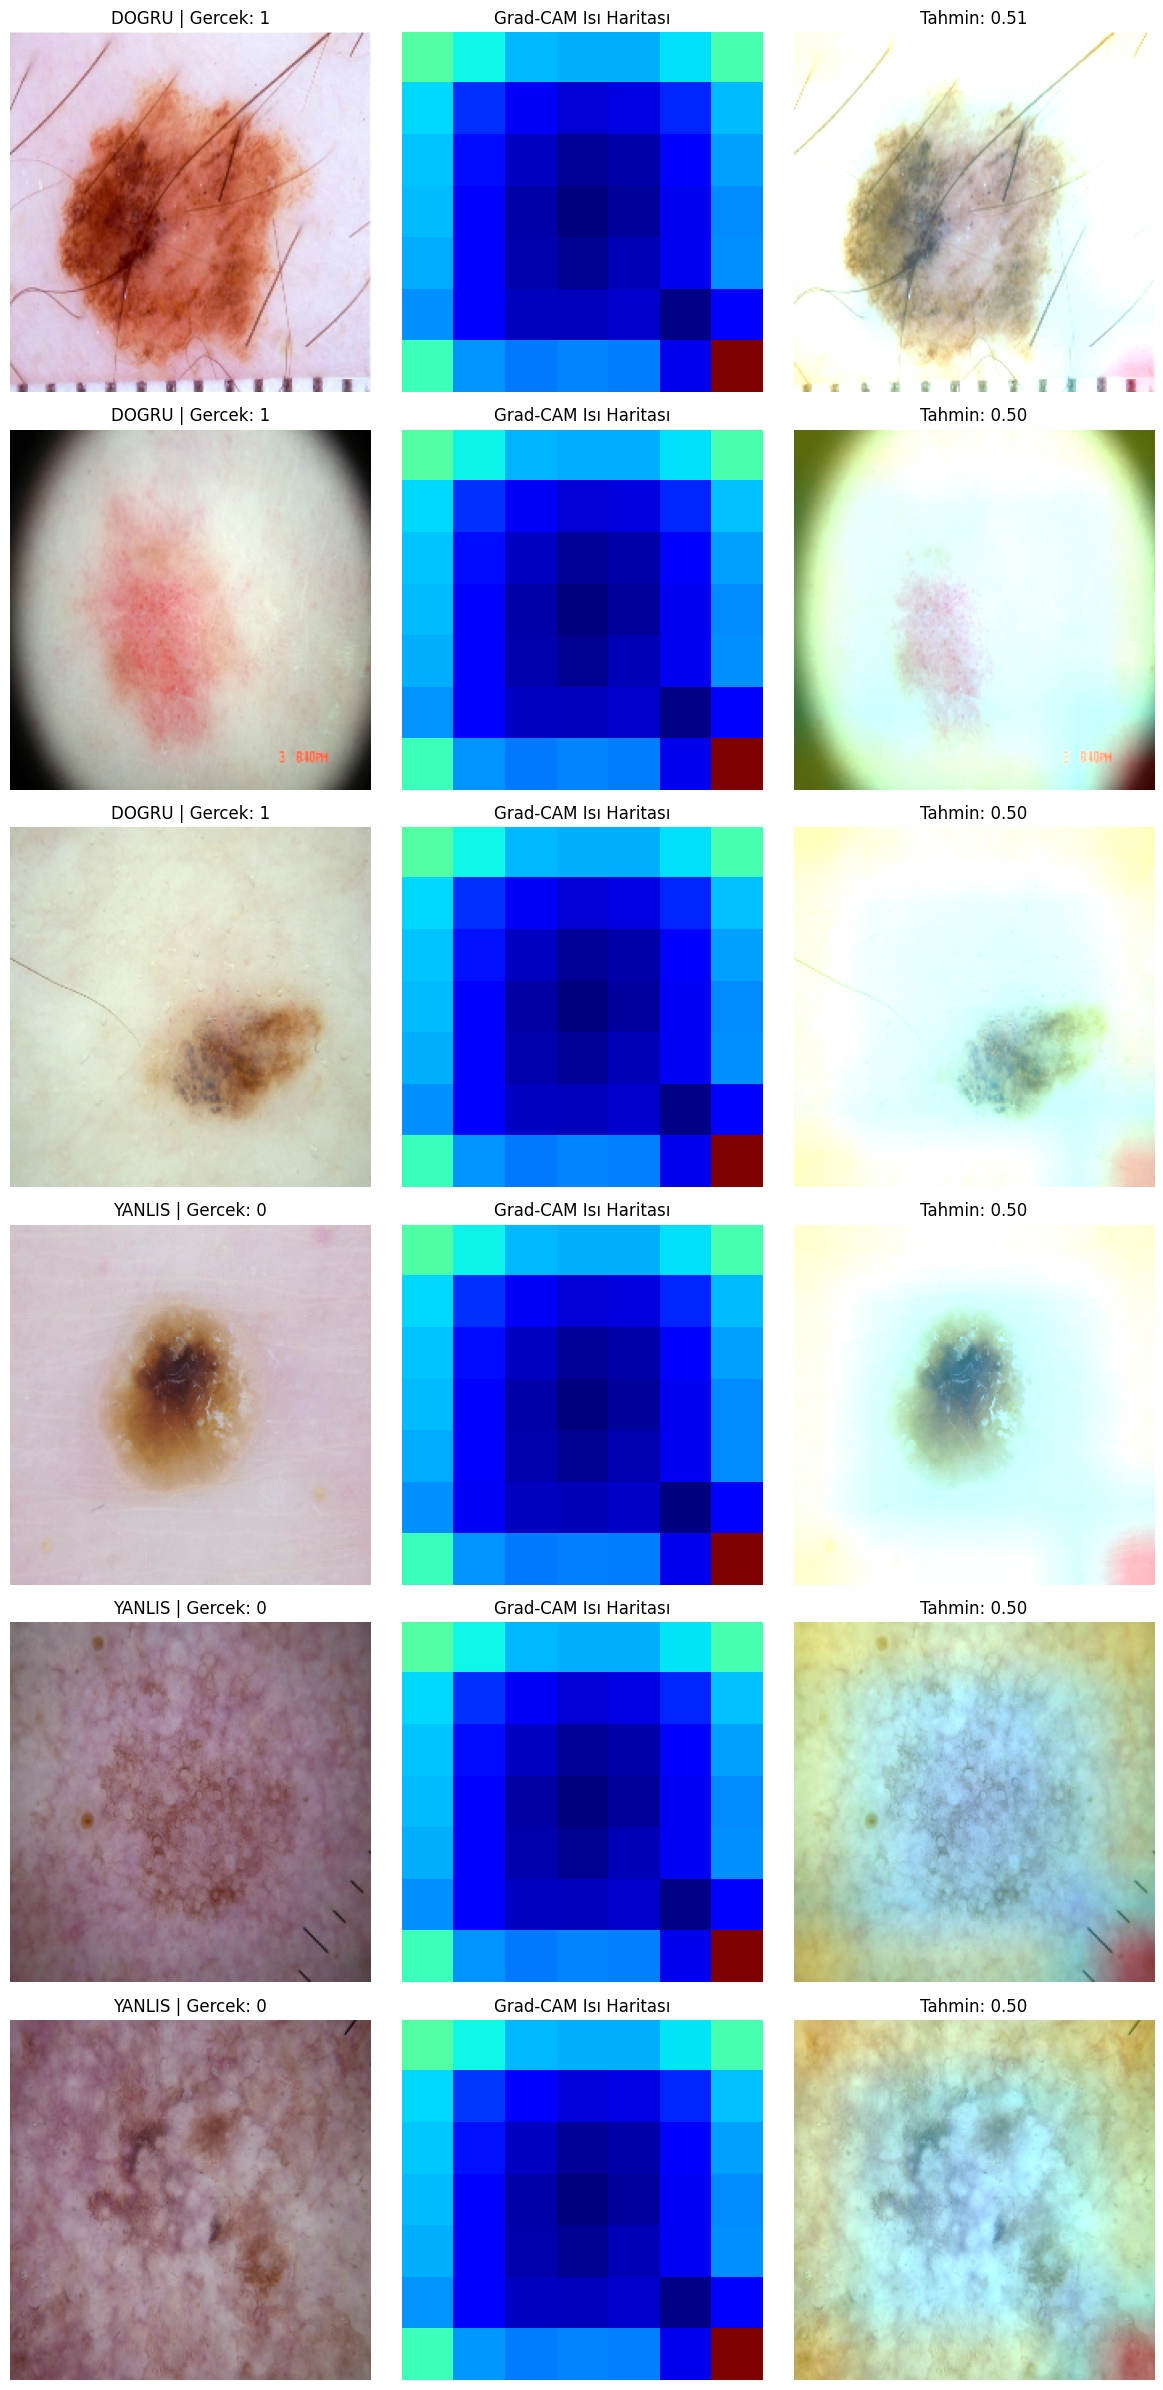

In [ ]:
import cv2

def run_gradcam_analysis(model, ds, layer_name, model_name):
    # Veriden örnekleri ve tahminleri al
    images, labels = next(iter(ds))
    preds = model.predict(images).flatten()
    binary_preds = (preds > 0.5).astype(int)

    # Doğru ve Yanlış indeksleri bul [cite: 149-150]
    correct_idx = np.where(binary_preds == labels.numpy())[0][:3]
    wrong_idx = np.where(binary_preds != labels.numpy())[0][:3]
    selected_indices = np.concatenate([correct_idx, wrong_idx])

    print(f"\n--- {model_name} Grad-CAM Analizi ---")
    fig, axes = plt.subplots(len(selected_indices), 3, figsize=(12, len(selected_indices)*4))

    for i, idx in enumerate(selected_indices):
        img_input = images[idx:idx+1]
        img_raw = images[idx].numpy()

        # Heatmap üretimi [cite: 153]
        heatmap = get_gradcam_heatmap(img_input, model, layer_name)
        # Overlay üretimi [cite: 154]
        overlay = overlay_heatmap(img_raw, heatmap)

        status = "DOGRU" if i < 3 else "YANLIS"

        axes[i, 0].imshow(img_raw)
        axes[i, 0].set_title(f"{status} | Gercek: {labels[idx]}")
        axes[i, 1].imshow(heatmap, cmap='jet')
        axes[i, 1].set_title("Grad-CAM Isı Haritası")
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title(f"Tahmin: {preds[idx]:.2f}")

        for ax in axes[i]: ax.axis('off')

    plt.tight_layout()
    plt.show()

# ANALİZİ BAŞLAT
# EfficientNet için 'top_conv', MobileNet için 'out_relu' kullanın.
run_gradcam_analysis(model_effnet, test_ds, "top_conv", "EfficientNet TL")

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf

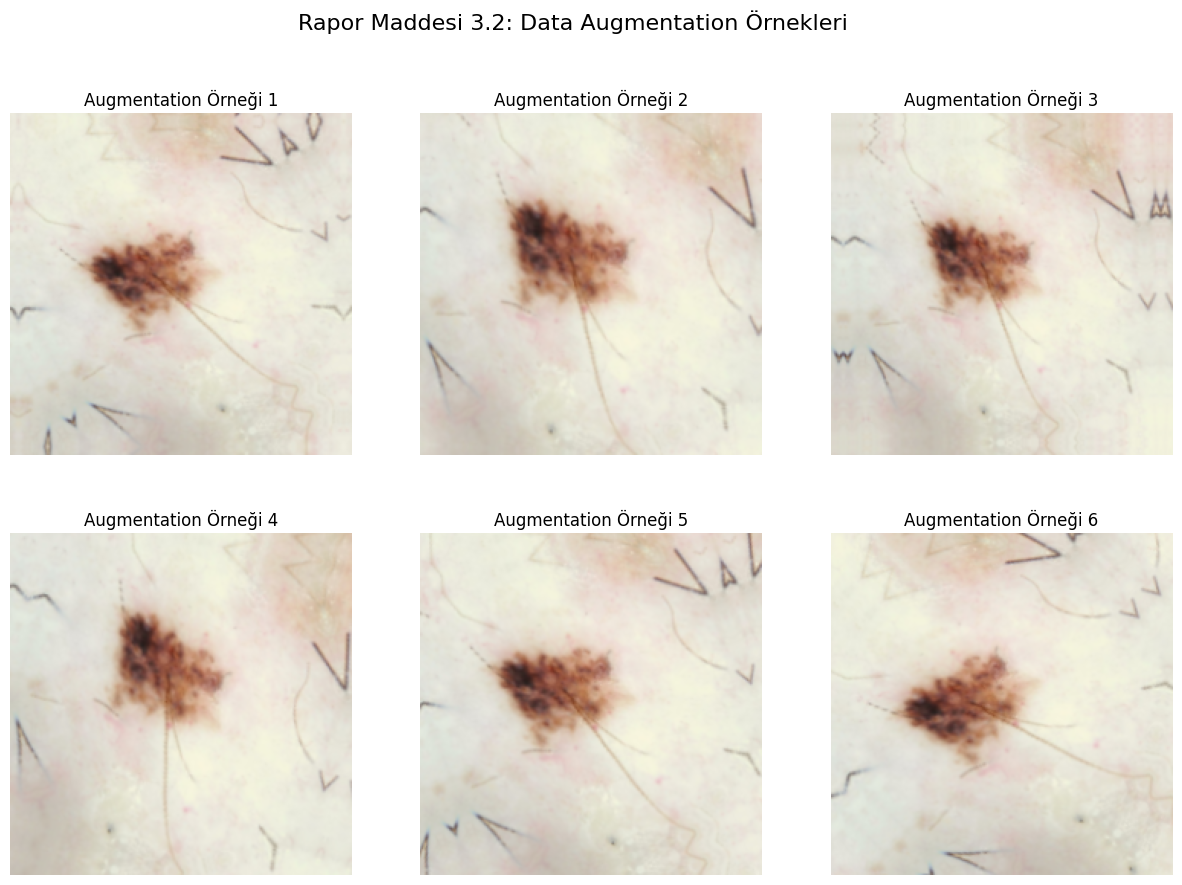

In [7]:
import matplotlib.pyplot as plt

# 1. Eğitim setinden bir örnek batch al [cite: 34]
for images, labels in train_ds.take(1):
    plt.figure(figsize=(15, 10))

    # Batch içindeki ilk görüntüyü seçelim: images[0]
    # Boyutu (224, 224, 3) olacaktır [cite: 20, 51]
    single_img = images[0]

    for i in range(6):
        # Augmentation uygula (training=True aktif edilmeli) [cite: 37, 38]
        # Katmana batch değil, doğrudan görüntünün kendisini gönderiyoruz
        augmented_image = aug_layer(single_img, training=True)

        plt.subplot(2, 3, i + 1)
        plt.imshow(augmented_image.numpy())
        plt.title(f"Augmentation Örneği {i+1}")
        plt.axis("off")

    plt.suptitle("Rapor Maddesi 3.2: Data Augmentation Örnekleri", fontsize=16)
    plt.show()